In [227]:
def analyze_tpo_day(df, sample_date, plot=True):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # --- Filter for selected day ---
    day_data = df[df.index.date == sample_date]
    if len(day_data) != 13:
        return None  # Skip incomplete sessions

    # --- Setup ---
    bracket_letters = list("ABCDEFGHIJKLM")
    price_bin_size = 0.25
    low = day_data['low'].min()
    high = day_data['high'].max()
    price_bins = np.arange(low, high + price_bin_size, price_bin_size)
    bin_centers = (price_bins[:-1] + price_bins[1:]) / 2

    # --- TPO matrix ---
    tpo_matrix = {price: [] for price in bin_centers}
    for i, (_, row) in enumerate(day_data.iterrows()):
        bracket = bracket_letters[i]
        bar_range = np.arange(row['low'], row['high'] + price_bin_size, price_bin_size)
        indices = np.digitize(bar_range, price_bins) - 1
        for idx in indices:
            if 0 <= idx < len(bin_centers):
                price = bin_centers[idx]
                if bracket not in tpo_matrix[price]:
                    tpo_matrix[price].append(bracket)

    # --- Key levels ---
    tpo_counts_array = np.array([len(letters) for letters in tpo_matrix.values()])
    total_tpos = np.sum(tpo_counts_array)
    sorted_indices = np.argsort(tpo_counts_array)[::-1]
    cumulative = 0
    value_area_indices = []
    for idx in sorted_indices:
        cumulative += tpo_counts_array[idx]
        value_area_indices.append(idx)
        if cumulative >= 0.7 * total_tpos:
            break

    vah = bin_centers[max(value_area_indices)]
    val = bin_centers[min(value_area_indices)]
    poc = bin_centers[np.argmax(tpo_counts_array)]
    day_open = day_data.iloc[0]['open']
    day_last = day_data.iloc[-1]['last']
    day_high = day_data['high'].max()
    day_low = day_data['low'].min()

    # --- Classify day type ---
    range_size = day_high - day_low
    poc_position = (poc - day_low) / range_size
    value_area_width = vah - val
    open_close_diff = abs(day_open - day_last)

    if poc_position < 0.3:
        poc_bias = 'lower'
    elif poc_position > 0.7:
        poc_bias = 'upper'
    else:
        poc_bias = 'central'

    if poc_bias == 'central' and value_area_width < 0.5 * range_size and open_close_diff < 5:
        day_type = 'Normal Day'
    elif poc_bias == 'central' and value_area_width < 0.7 * range_size:
        day_type = 'Normal Variation Day'
    elif poc_bias in ['upper', 'lower'] and open_close_diff > 10:
        day_type = 'Trend Day'
    elif day_open < poc < day_last or day_open > poc > day_last:
        day_type = 'Neutral Day'
    else:
        day_type = 'Unknown'

    # --- Optional plot ---
    if plot:
        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])  # left: histogram, right: TPO chart

        # --- Active price levels ---
        active_prices = [price for price, letters in tpo_matrix.items() if letters]
        tpo_counts = [len(tpo_matrix[price]) for price in active_prices]

        # --- Left subplot: TPO count histogram ---
        ax0 = plt.subplot(gs[0])
        ax0.barh(active_prices, tpo_counts, color='lightblue', edgecolor='blue')
        ax0.set_xlabel("TPO Count")
        ax0.set_ylabel("Price Level")
        ax0.set_title("TPO Distribution")
        ax0.grid(True, linestyle='--', alpha=0.3)
        ax0.invert_yaxis()

        # --- Right subplot: TPO letters by time bracket ---
        ax1 = plt.subplot(gs[1])
        bracket_positions = {letter: i for i, letter in enumerate(bracket_letters)}

        for price in active_prices:
            for letter in sorted(tpo_matrix[price]):
                x = bracket_positions.get(letter, -1)
                ax1.text(x, price, letter, fontsize=8, fontfamily='monospace')

        ax1.set_ylim(min(active_prices) - 0.5, max(active_prices) + 0.5)
        ax1.set_xlim(-0.5, len(bracket_letters) - 0.5)
        ax1.set_xticks(range(len(bracket_letters)))
        ax1.set_xticklabels(bracket_letters)
        ax1.set_xlabel("Time Brackets")
        ax1.set_title(f"TPO Chart for {sample_date} ({day_type})")
        ax1.grid(True, linestyle='--', alpha=0.3)

        # Annotate key levels
        def annotate_level(ax, y, label, color):
            ax.axhline(y, color=color, linestyle='--', linewidth=1)
            ax.text(len(bracket_letters) - 0.5, y, label, va='center', ha='right', color=color, fontsize=8)

        annotate_level(ax1, day_open, 'Open', 'green')
        annotate_level(ax1, day_last, 'Last', 'orange')
        annotate_level(ax1, vah, 'VAH', 'purple')
        annotate_level(ax1, val, 'VAL', 'purple')
        annotate_level(ax1, poc, 'POC', 'red')

        plt.tight_layout()
        plt.show()

    return {
        'date': sample_date,
        'day_type': day_type,
        'poc': poc,
        'vah': vah,
        'val': val,
        'open': day_open,
        'last': day_last,
        'range': range_size,
        'tpo_matrix': tpo_matrix
    }


In [228]:
results = []
for date in sorted(set(df.index.date)):
    result = analyze_tpo_day(df, date, plot=False)
    if result:
        results.append(result)

# Convert to DataFrame for analysis
summary_df = pd.DataFrame(results)
print(summary_df[['date', 'day_type', 'poc', 'vah', 'val']])

           date              day_type       poc       vah       val
0    2021-12-09  Normal Variation Day  4683.625  4691.625  4678.875
1    2021-12-10  Normal Variation Day  4692.125  4699.375  4683.375
2    2021-12-13  Normal Variation Day  4672.875  4680.375  4665.375
3    2021-12-14               Unknown  4605.875  4633.875  4598.625
4    2021-12-15             Trend Day  4613.875  4653.375  4603.875
..          ...                   ...       ...       ...       ...
676  2024-08-26  Normal Variation Day  5637.875  5646.625  5627.125
677  2024-08-27             Trend Day  5643.625  5647.375  5627.125
678  2024-08-28               Unknown  5608.375  5640.625  5582.625
679  2024-08-29             Trend Day  5651.375  5658.375  5605.375
680  2024-08-30             Trend Day  5613.875  5642.875  5608.875

[681 rows x 5 columns]


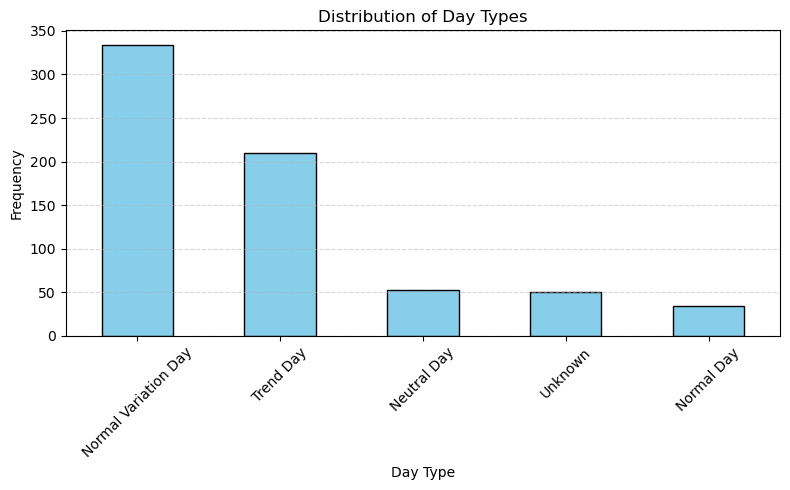

In [229]:
import matplotlib.pyplot as plt

# Count occurrences of each day type
day_type_counts = summary_df['day_type'].value_counts()

# Plot as bar chart
plt.figure(figsize=(8, 5))
day_type_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Day Types")
plt.xlabel("Day Type")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [232]:
import random

# Pick 3 random dates from the summary
sample_dates = random.sample(list(summary_df['date']), 3)


📅 Plotting TPO for 2023-09-22


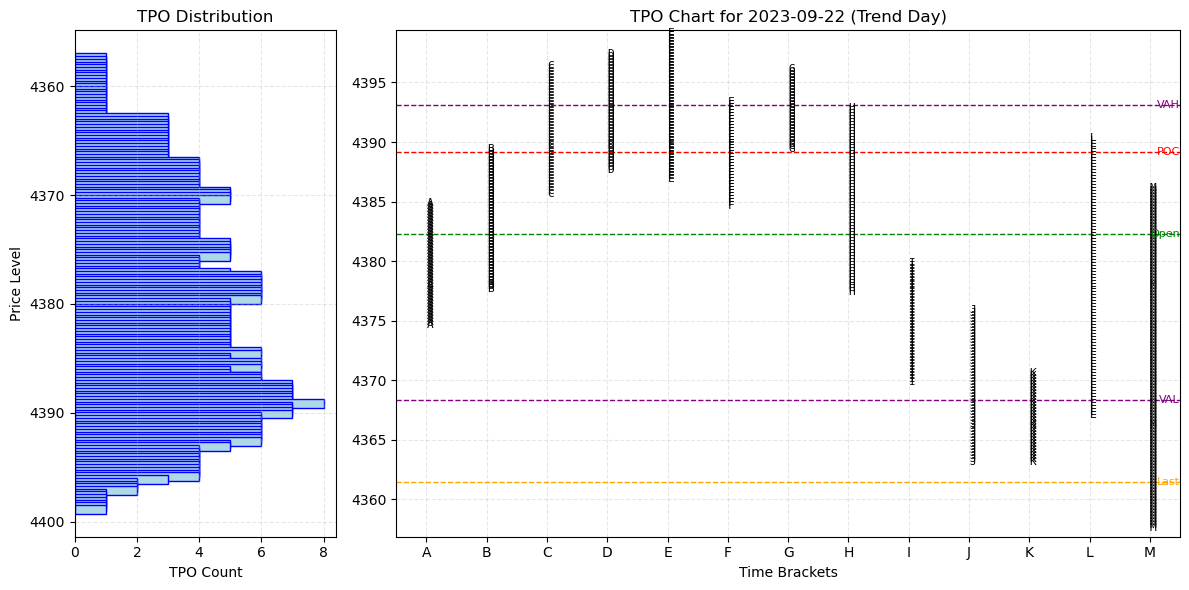


📅 Plotting TPO for 2022-09-15


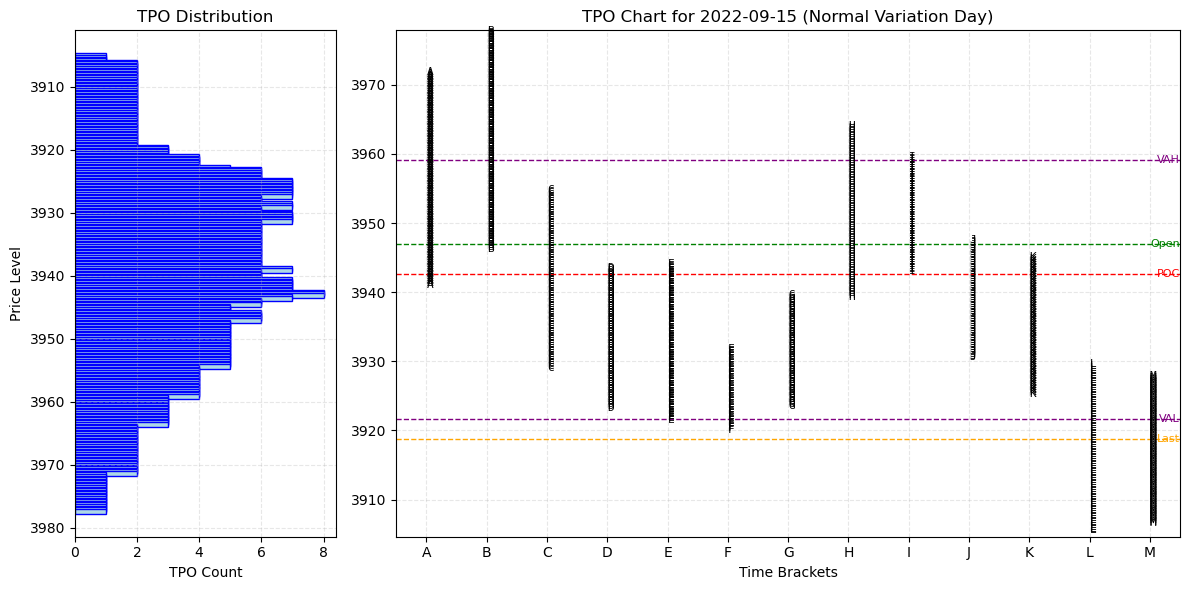


📅 Plotting TPO for 2022-06-08


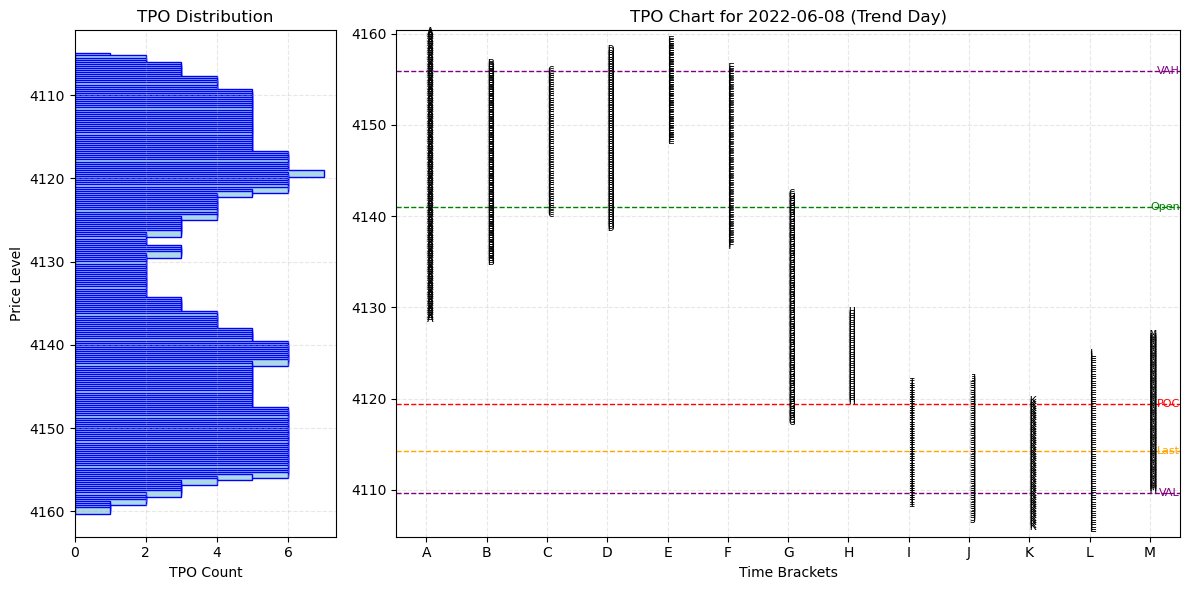

In [233]:
for date in sample_dates:
    print(f"\n📅 Plotting TPO for {date}")
    analyze_tpo_day(df, date, plot=True)